In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

## Uploading and preprocessing data

In [3]:
def preprocessing_air_data(df):
    df['date_time']=pd.to_datetime(df['date_time'], origin='1899-12-30', unit='D')
    df['date_time'] = pd.to_datetime(df['date_time'], format='%d/%m/%Y')
    
    # # Replace '<Samp' values with 0
    # df = df.replace('<Samp', 0)
    
    # Convert all non-numeric values (except dates) to NaN
    numeric_columns = df.columns[1:]  # All columns except the date column
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # # Convert negative values to 0
    # df[numeric_columns] = df[numeric_columns].clip(lower=0)

    # convert negative values to NaN
    df[numeric_columns] = df[numeric_columns].map(lambda x: np.nan if x < 0 else x)

    return df

In [4]:
def aggregate_half_monthly(df):
    """
    transform daily data to half-monthly data
    """
    
    # Calculate row means excluding NaN values
    # axis=1 means calculate across columns
    # skipna=True means ignore NaN values   
    df['CO_Israel'] = df.iloc[:, 1:].mean(axis=1, skipna=True)
    df['half_month'] = df['date_time'].dt.day.apply(lambda x: 1 if x <= 15 else 2)
    
    df_downsampled = df.groupby([
        df['date_time'].dt.year.rename('year'),
        df['date_time'].dt.month.rename('month'),
        'half_month'
    ])[df.columns[1:-1]].mean().reset_index()

    # Create proper datetime for the downsampled data (using the 1st and 16th of each month)
    df_downsampled['date'] = pd.to_datetime(
        df_downsampled.apply(
            lambda x: f"{int(x['year'])}-{int(x['month'])}-{1 if x['half_month']==1 else 16}",
            axis=1
        ))

    df_downsampled = df_downsampled[["date", "CO_Israel", *df_downsampled.columns.difference(["date", "CO_Israel"])]]
    df_downsampled.drop(["year", "month", "half_month"], axis=1, inplace=True)
    return df_downsampled

In [5]:
air = pd.read_csv('data/final_data.csv')
air = preprocessing_air_data(air)
# air_longer = air.melt(id_vars=['date_time'], var_name='station', value_name='co')
# air_longer.to_csv("data/co_clean.csv", index=False)

# Missing Values Analysis

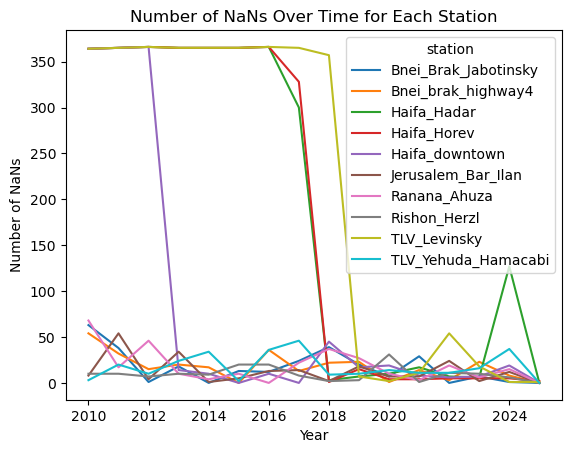

In [5]:
air_long = air.melt(id_vars = ['date_time'], var_name = 'station', value_name='CO_level')

nan_by_year = air_long.groupby([air_long['date_time'].dt.year, 
                      'station'])['CO_level'].apply(lambda x: x.isna().sum()).reset_index(name = "NaN Count")
					  
sns.lineplot(data = nan_by_year, x='date_time', y='NaN Count', hue='station')
plt.xlabel("Year")
plt.ylabel("Number of NaNs")
plt.title("Number of NaNs Over Time for Each Station")
plt.legend(title="station")
plt.show()

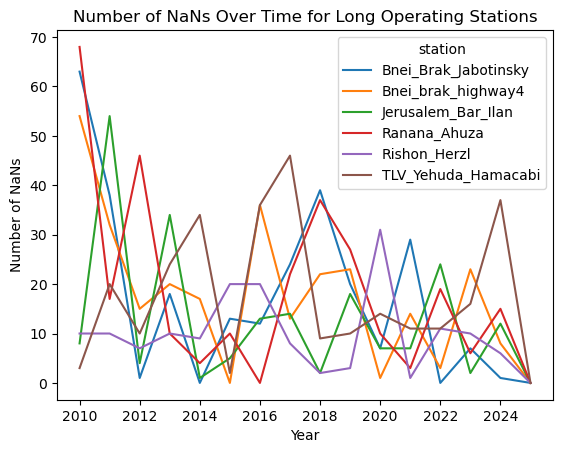

In [6]:
# examine only stations which are active since 2010
nan_by_year_old = nan_by_year[~nan_by_year.station.str.contains("Haifa|Levinsky")]
sns.lineplot(data = nan_by_year_old, x='date_time', y='NaN Count', hue='station')
plt.xlabel("Year")
plt.ylabel("Number of NaNs")
plt.title("Number of NaNs Over Time for Long Operating Stations")
plt.legend(title="station")
plt.show()

In [7]:
nan_by_year_old.groupby('station')['NaN Count'].sum().reset_index().sort_values(by='NaN Count', ascending = True)

,station,NaN Count
4,Rishon_Herzl,158
2,Jerusalem_Bar_Ilan,205
0,Bnei_Brak_Jabotinsky,272
1,Bnei_brak_highway4,281
5,TLV_Yehuda_Hamacabi,283
3,Ranana_Ahuza,294


It appears that each year every stations has a few dozens missing values. That is not too bad if it is spread evenly across months. lets check this.

In [8]:
nan_by_date = (
    air_long.groupby([air_long['date_time'].dt.year, air_long['date_time'].dt.month, 'station'])['CO_level']
    .apply(lambda x: x.isna().sum())
    .rename_axis(['Year','Month', 'station'])
    .reset_index(name="NaN Count")
)
nan_by_date['date'] = pd.to_datetime(nan_by_date[['Year','Month']].assign(day=1))
nan_by_date.drop(["Year","Month"], axis=1, inplace=True)

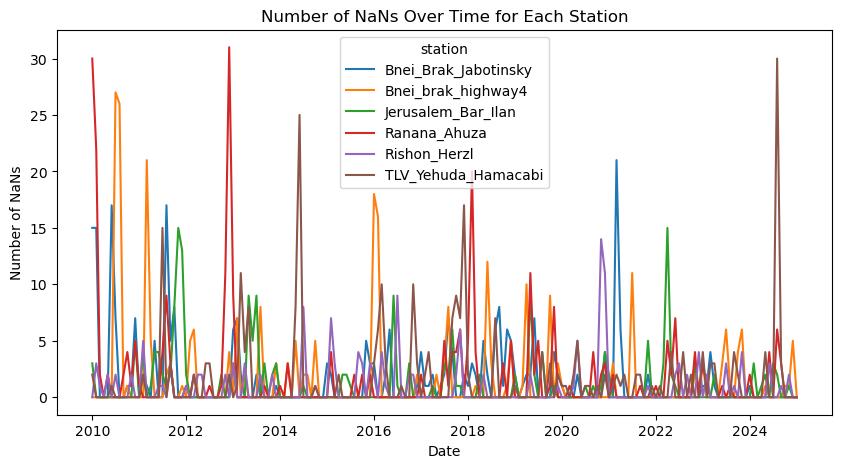

In [9]:
nan_by_date_old = nan_by_date[~nan_by_date.station.str.contains("Haifa|Levinsky")]

plt.figure(figsize = (10,5))
sns.lineplot(data = nan_by_date_old, x='date', y='NaN Count', hue='station')
plt.xlabel("Date")
plt.ylabel("Number of NaNs")
plt.title("Number of NaNs Over Time for Each Station")
plt.legend(title="station")

In [51]:
nan_by_date_old[(nan_by_date_old['station']=='Bnei_brak_highway4') & (nan_by_date_old['date'].dt.year==2010)]

,station,NaN Count,date
1,Bnei_brak_highway4,0,2010-01-01
11,Bnei_brak_highway4,0,2010-02-01
21,Bnei_brak_highway4,0,2010-03-01
31,Bnei_brak_highway4,0,2010-04-01
41,Bnei_brak_highway4,0,2010-05-01
51,Bnei_brak_highway4,0,2010-06-01
61,Bnei_brak_highway4,27,2010-07-01
71,Bnei_brak_highway4,26,2010-08-01
81,Bnei_brak_highway4,0,2010-09-01
91,Bnei_brak_highway4,1,2010-10-01


# Seasonal Decomposition by Station

In [6]:
air_monthly = aggregate_half_monthly(air)
air_monthly_longer = air_monthly.melt(id_vars=['date'], var_name='station', value_name='CO_level')

In [7]:
# extract time decomposition for each station
def extract_decomposition(group, period_months, value_name='CO_level'):
    group = group.dropna(subset=[value_name])
    decomposition = seasonal_decompose(group[value_name], period=period_months, model='additive', extrapolate_trend='freq')
    group['Observed'] = decomposition.observed
    group['Trend'] = decomposition.trend
    group['Seasonal'] = decomposition.seasonal
    group['Residuals'] = decomposition.resid
    return group

In [8]:
air_decomposition = (
    air_monthly_longer.set_index("station")
    .groupby("station", group_keys=False, sort=False)
    .apply(extract_decomposition, period_months=24)
    .reset_index()
)

In [13]:
air_decomposition.station.unique()

array(['CO_Israel', 'Bnei_Brak_Jabotinsky', 'Bnei_brak_highway4',
       'Jerusalem_Bar_Ilan', 'Ranana_Ahuza', 'Rishon_Herzl',
       'TLV_Yehuda_Hamacabi'], dtype=object)

In [32]:
air_decomposition[air_decomposition.date.dt.year == 2018]

,station,date,CO_level,Observed,Trend,Seasonal,Residuals
192,CO_Israel,2018-01-01,0.362444,0.362444,0.412033,0.070596,-0.120184
193,CO_Israel,2018-01-16,0.324583,0.324583,0.413747,0.089105,-0.178268
194,CO_Israel,2018-02-01,0.519444,0.519444,0.420007,0.068961,0.030477
195,CO_Israel,2018-02-16,0.465641,0.465641,0.428196,0.044582,-0.007137
196,CO_Israel,2018-03-01,0.513556,0.513556,0.436663,0.009913,0.066979
...,...,...,...,...,...,...,...
2390,TLV_Yehuda_Hamacabi,2018-10-16,0.568750,0.568750,0.658647,0.038796,-0.128694
2391,TLV_Yehuda_Hamacabi,2018-11-01,0.553333,0.553333,0.641008,0.087378,-0.175053
2392,TLV_Yehuda_Hamacabi,2018-11-16,0.780000,0.780000,0.631434,0.075773,0.072793
2393,TLV_Yehuda_Hamacabi,2018-12-01,0.653333,0.653333,0.621442,0.103213,-0.071322


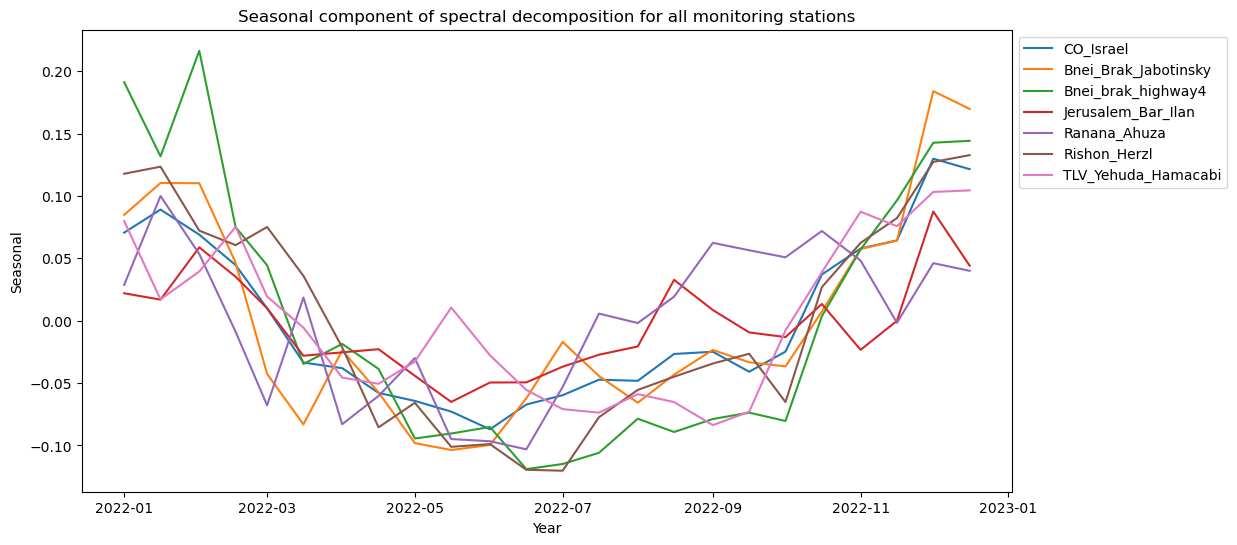

In [36]:
plot_spectral(air_decomposition[air_decomposition.date.dt.year == 2022], "Seasonal")

In [13]:
# Plot using FacetGrid
def plot_spectral_facets(air_decomposition_dat, spectral_component, cycle, save_as_file = False):
    g = sns.FacetGrid(air_decomposition_dat, col='station', col_wrap=3,  sharey=True, sharex=True, height=4, aspect=1.5)
    g.map(sns.lineplot, "date", spectral_component)
    
    # Add title and adjust layout
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle("{} Component of Spectral Decomposition for Each Monitoring Station ({})".format(spectral_component, cycle))

    if save_as_file:
        plt.savefig("{}_{}.png".format(cycle, spectral_component), dpi=300, bbox_inches='tight')
    
    plt.show()

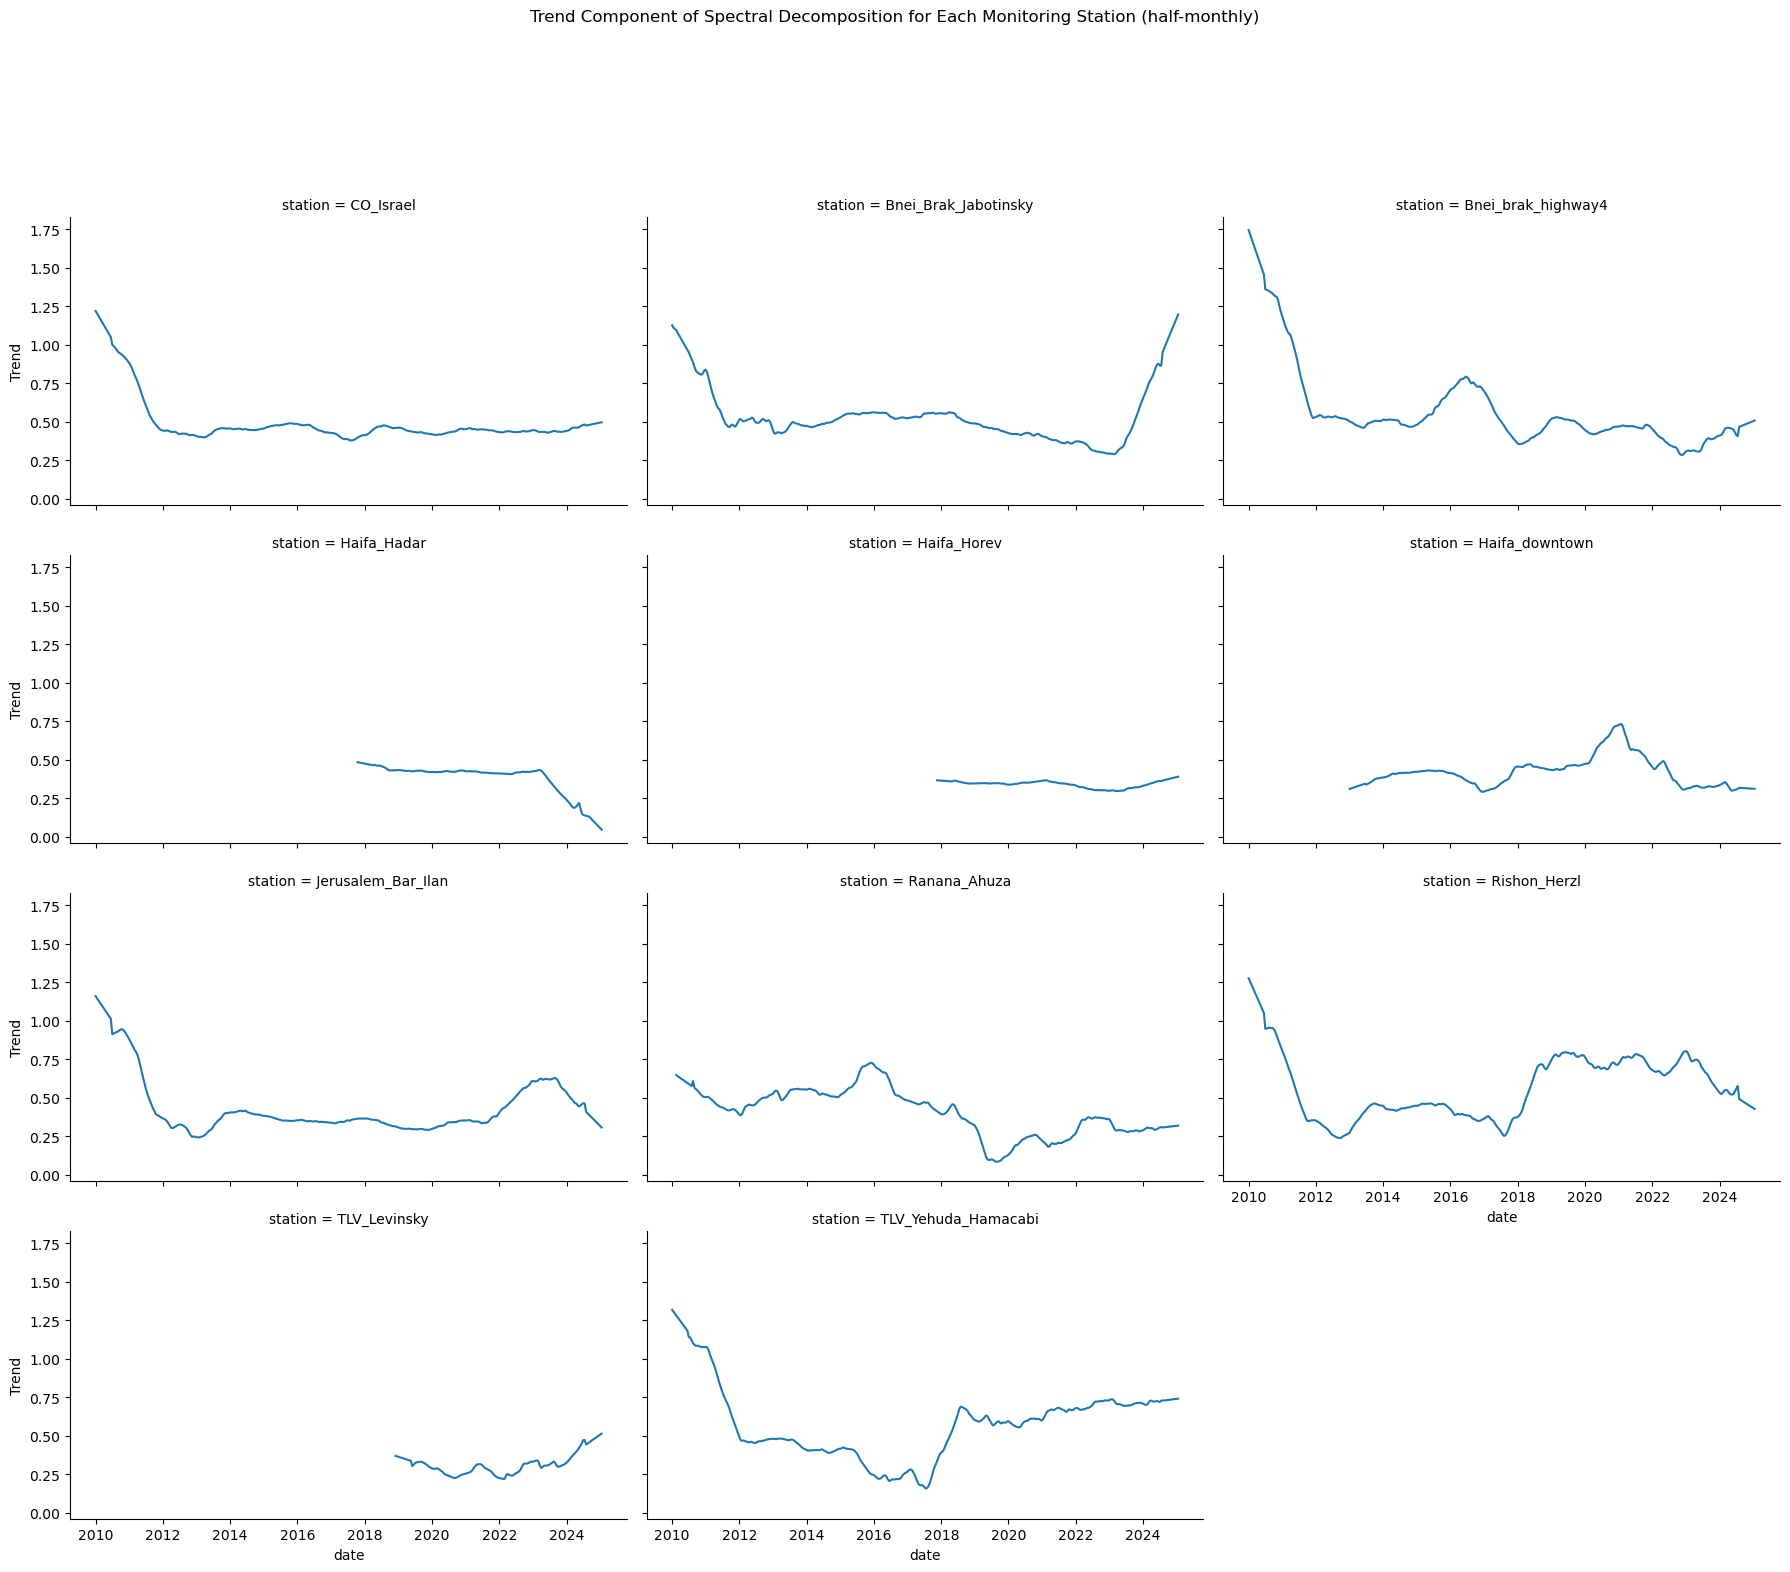

In [14]:
plot_spectral_facets(air_decomposition, "Trend", "half-monthly")

While all monitoring stations active at 2010 shows a significant decrease in pollution from 2010 to 2012, the monotonic trend observed afterwards in the state-average data is not consistently reflected at the individual station level. For example, the stations at TLV - Yehuda Hamacabi and Rishon - Herzl exhibits a substantial increase in pollution at 2018, with a similar but milder rise observed Haifa Downtown that same year. Towards 2024, some stations, such as those in Bnei Brak, shows increasing pollution levels, whereas others, including Rishon, Jerusalem, and Haifa Hadar, indicate a decline. 

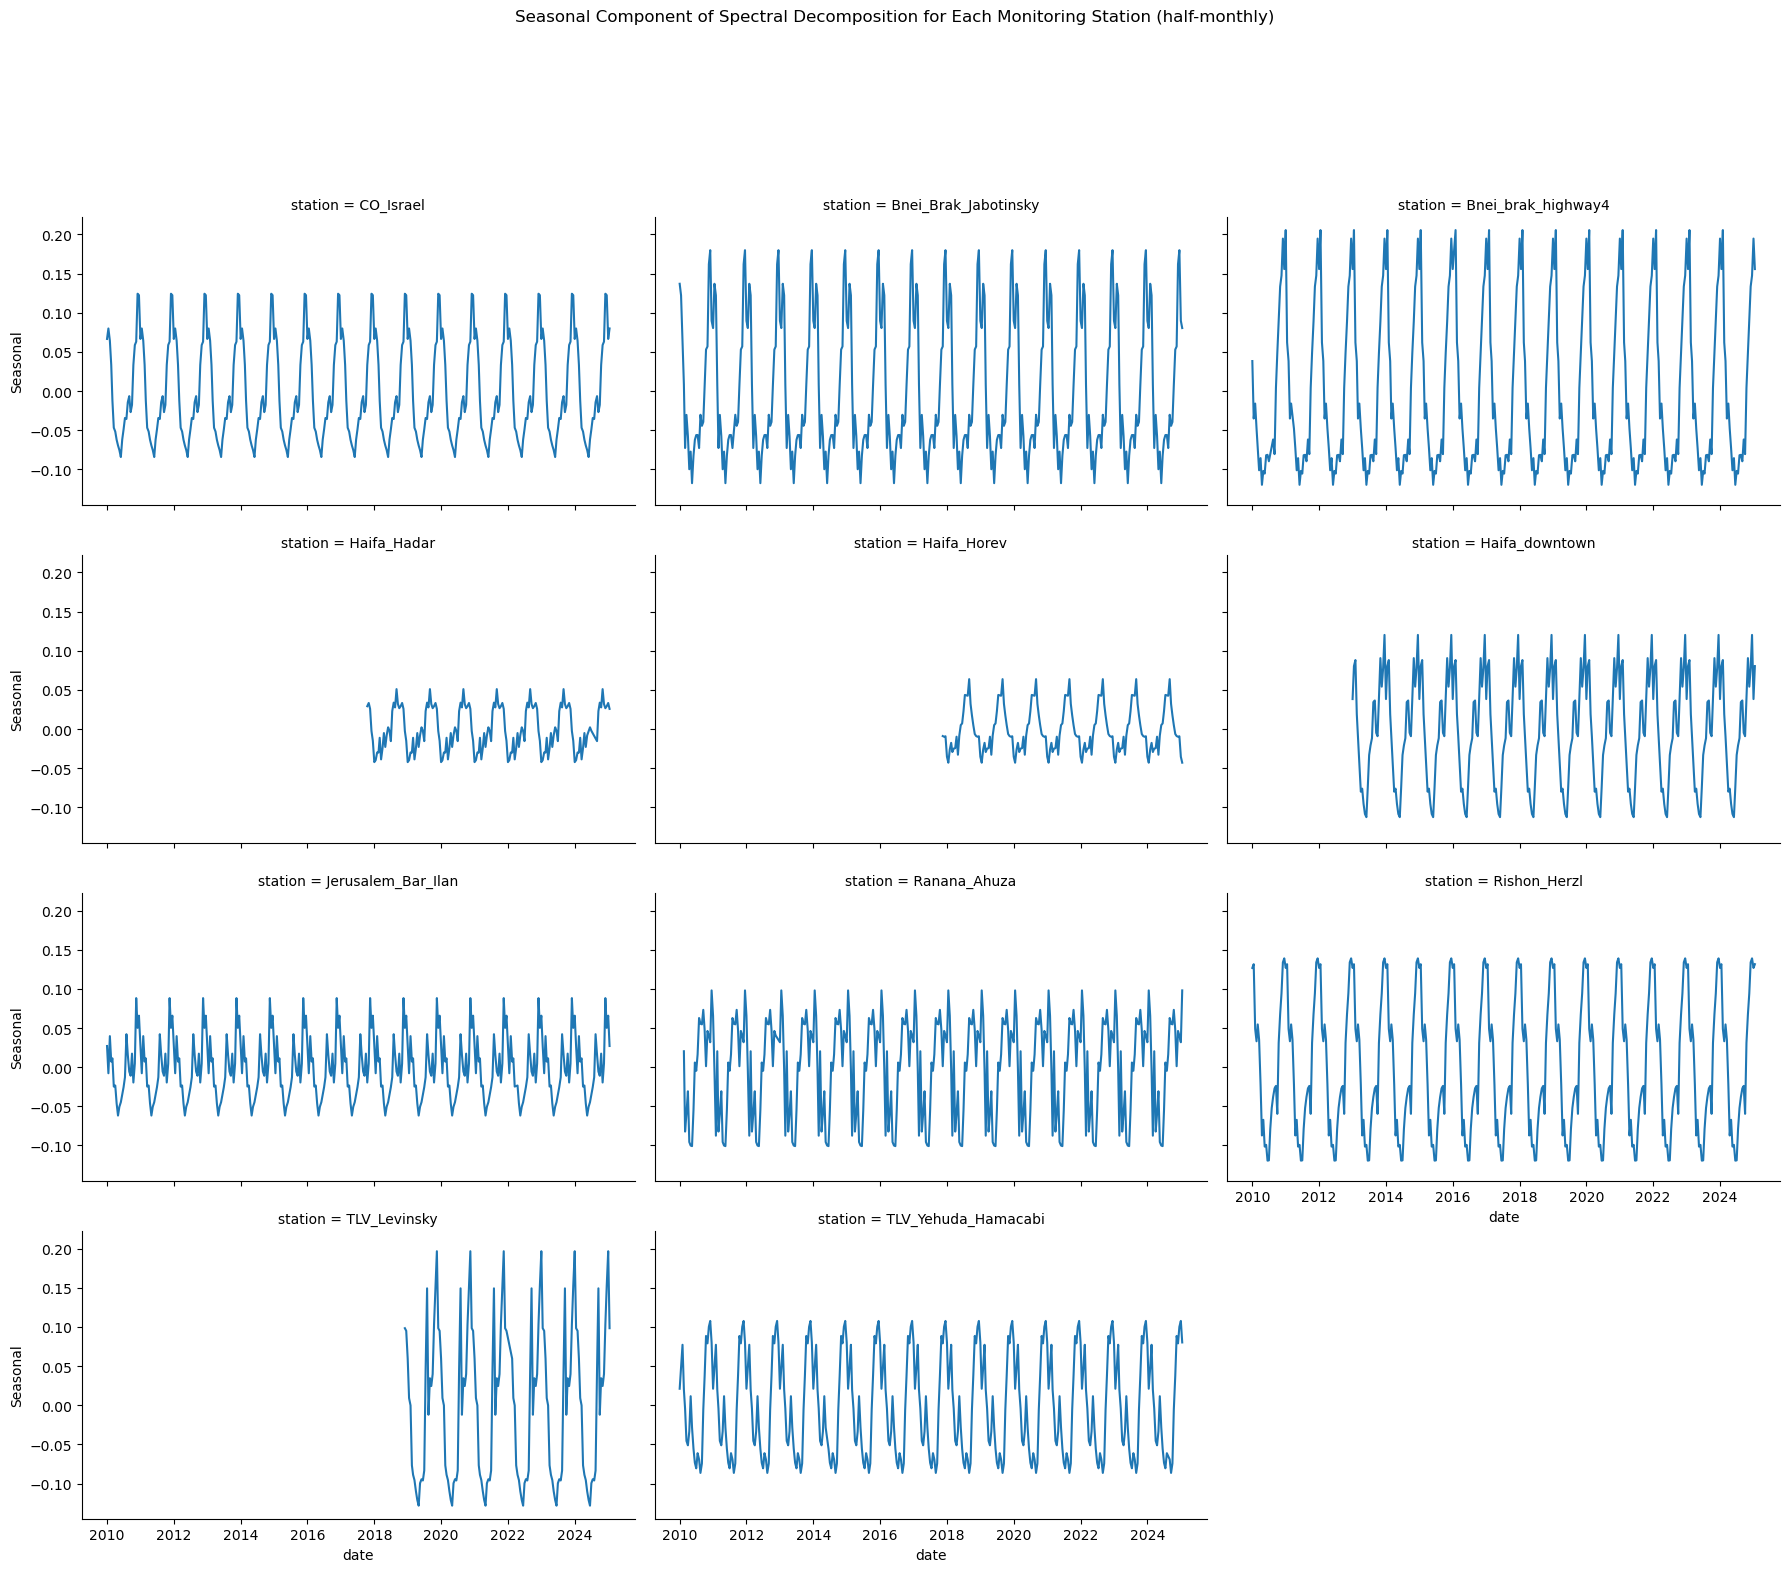

In [15]:
plot_spectral_facets(air_decomposition, "Seasonal", "half-monthly")

In [33]:
def plot_spectral(df, spectral_component):
    plt.figure(figsize = (12, 6))
    sns.lineplot(data = df, x="date", y=spectral_component, hue = "station")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("Year")
    plt.ylabel(spectral_component)
    plt.title("{} component of spectral decomposition for all monitoring stations".format(spectral_component))
    plt.show()

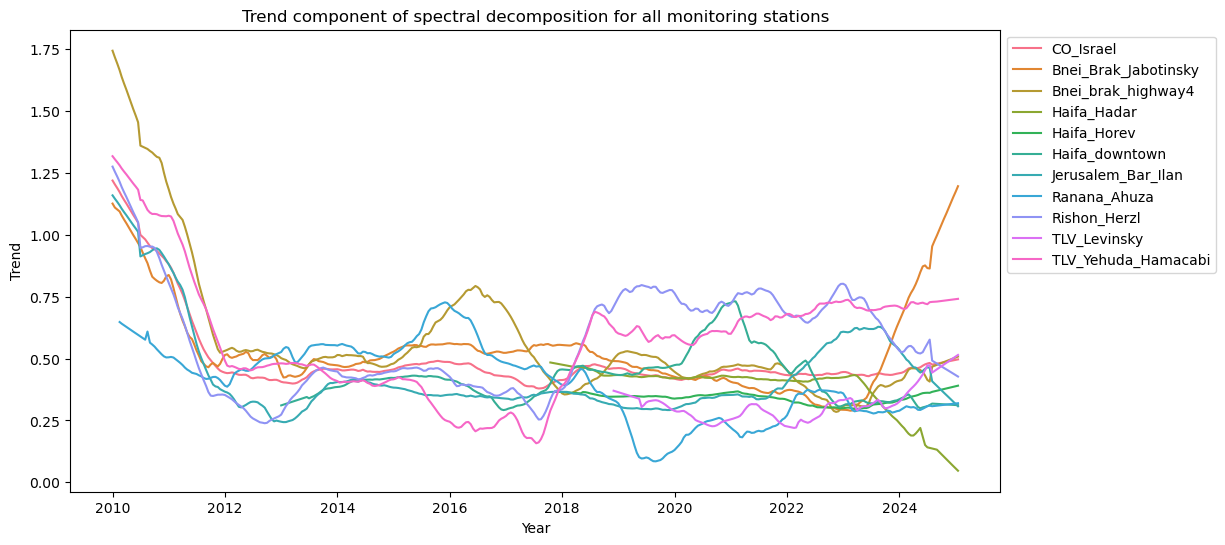

In [17]:
plot_spectral(air_decomposition, "Trend")

In [18]:
subset_center = air_decomposition[air_decomposition['station'].str.contains('Bnei_Brak|Israel|TLV|Rishon|Rana', case=False, na = False)]

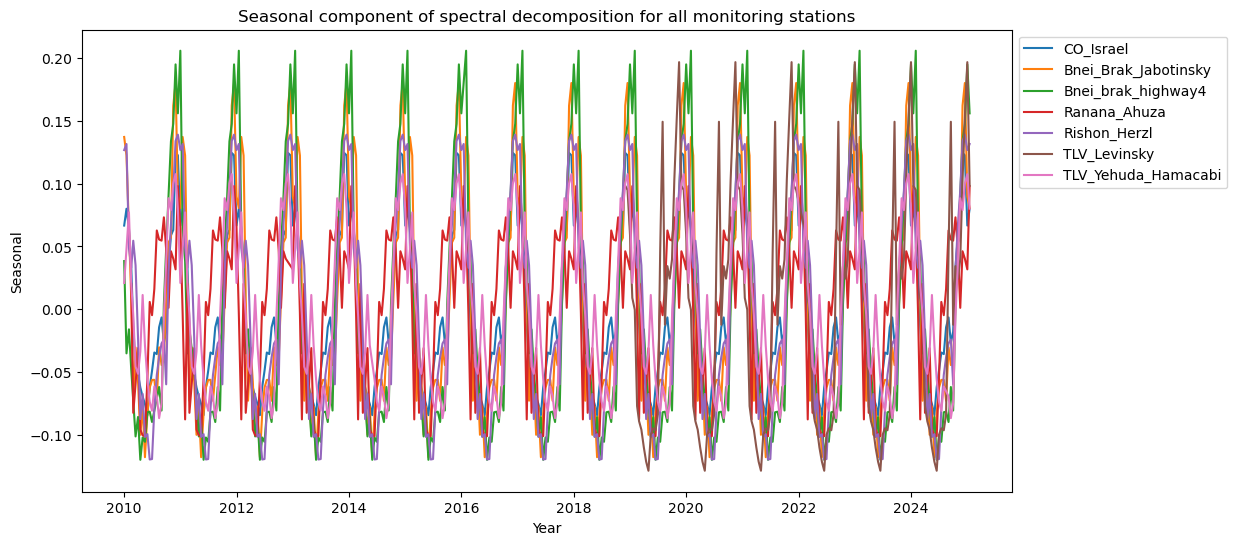

In [19]:
plot_spectral(subset_center, "Seasonal")

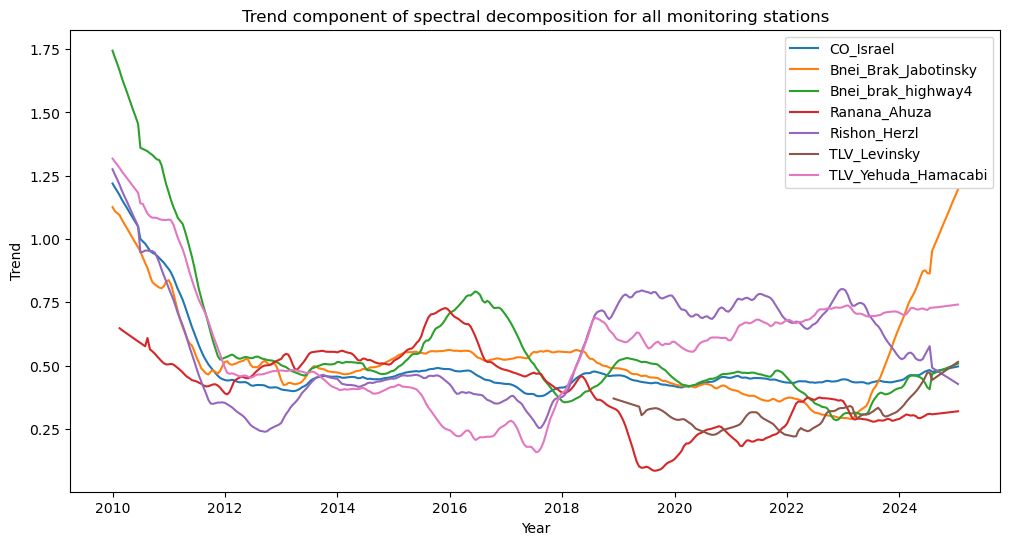

In [20]:
plot_spectral(subset_center, "Trend")

Tasks:
- oberved data from prior 2010
- compare to trends in another cars pollutant

# Monthly average impact

In [21]:
# data preprocessing
air_monthly = air.groupby([
        air['date_time'].dt.year.rename('year'),
        air['date_time'].dt.month.rename('month'),
    ])[air.columns[1:-1]].mean().reset_index()
air_monthly['date'] = pd.to_datetime(air_monthly[['year','month']].assign(day=1))
# air_monthly = air_monthly.drop(["year","month"], axis =1)
# air_monthly = air_monthly[["date", "CO_Israel", *air_monthly.columns.difference(["date", "CO_Israel"])]]

In [22]:
air_monthly_longer = air_monthly.melt(id_vars=['date'], var_name='station', value_name='CO_level')

In [23]:
air_monthly_decomposition = (
    air_monthly_longer.set_index("station")
    .groupby("station", group_keys=False, sort=False)
    .apply(extract_decomposition, period_months=12)
    .reset_index()
)

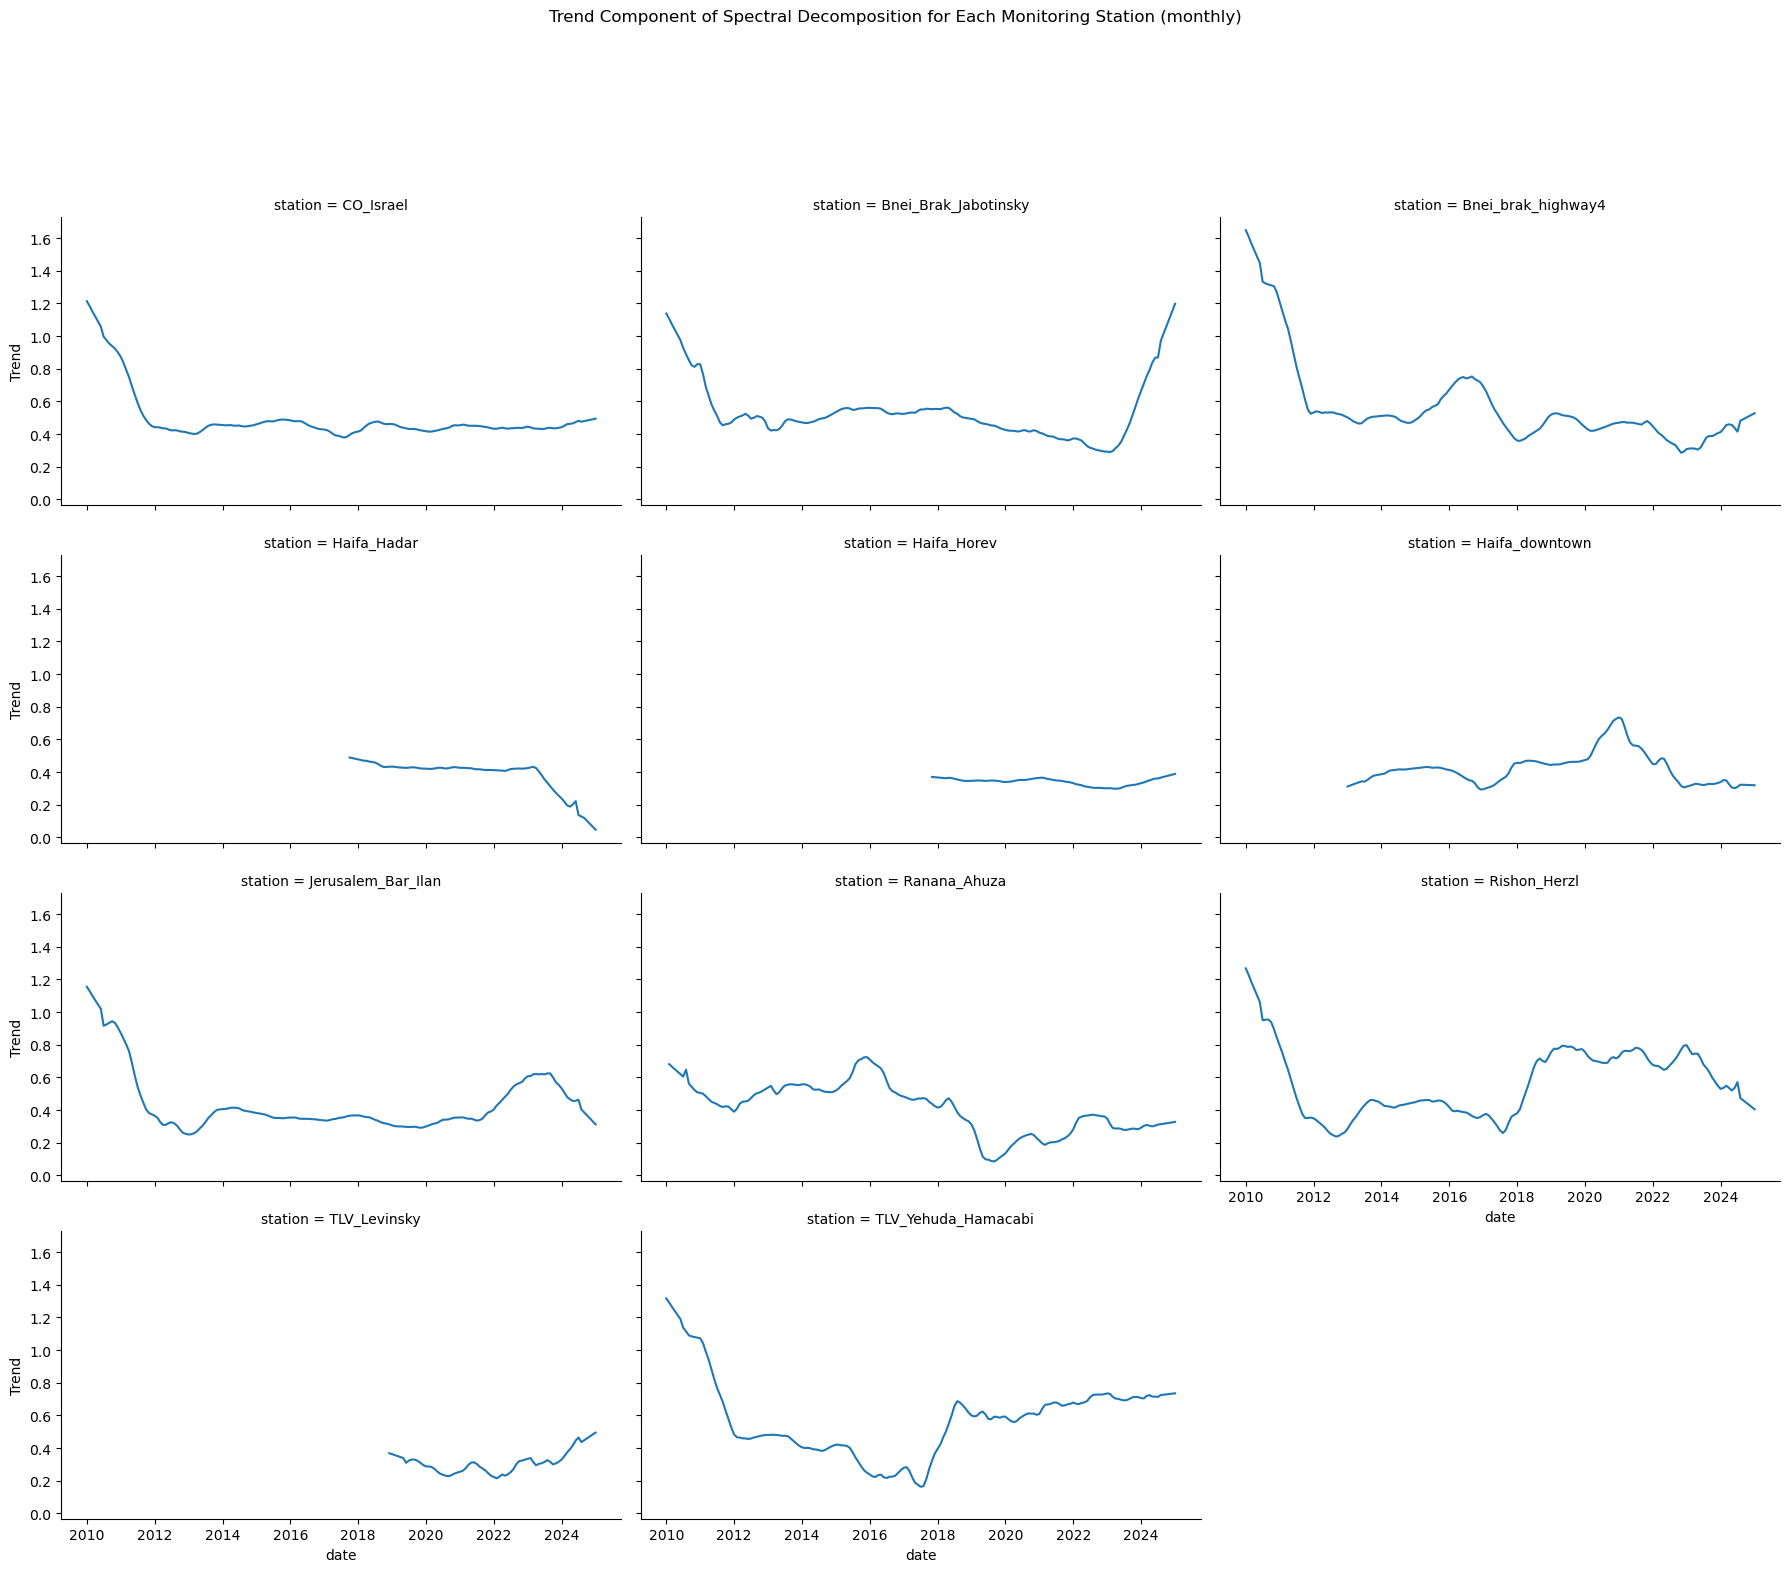

In [24]:
plot_spectral_facets(air_monthly_decomposition, "Trend", "monthly")

Not surprisingly, that looks the same as the half-monthly trends. Lets examine the seasonal components:

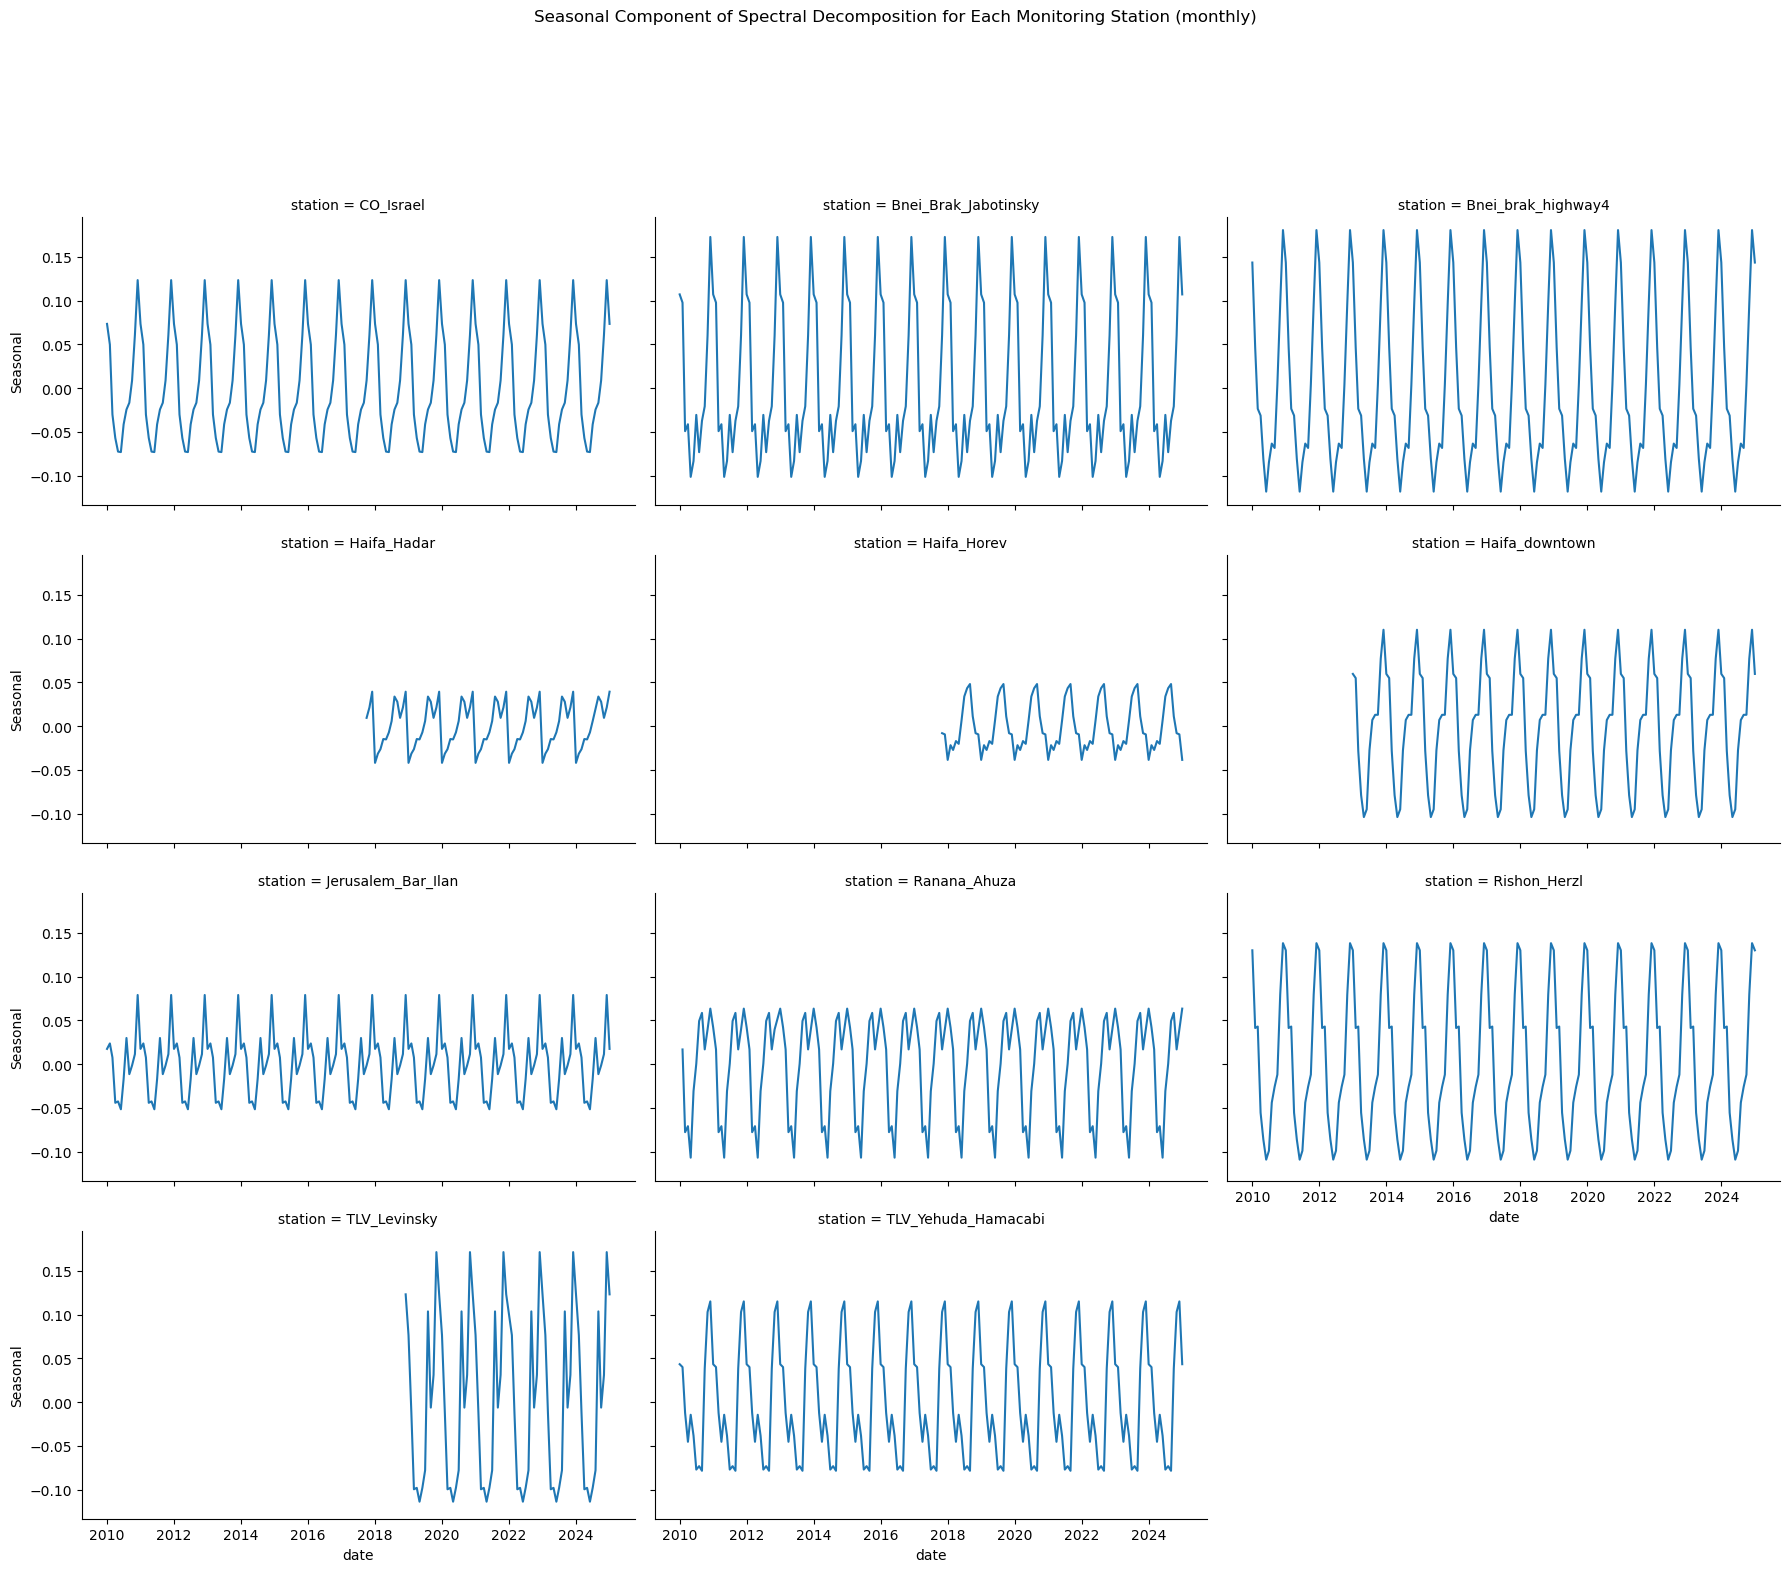

In [25]:
plot_spectral_facets(air_monthly_decomposition, "Seasonal", "monthly")

That is a bit less noisy but still showing the same pattern. Lets try and stack them together:

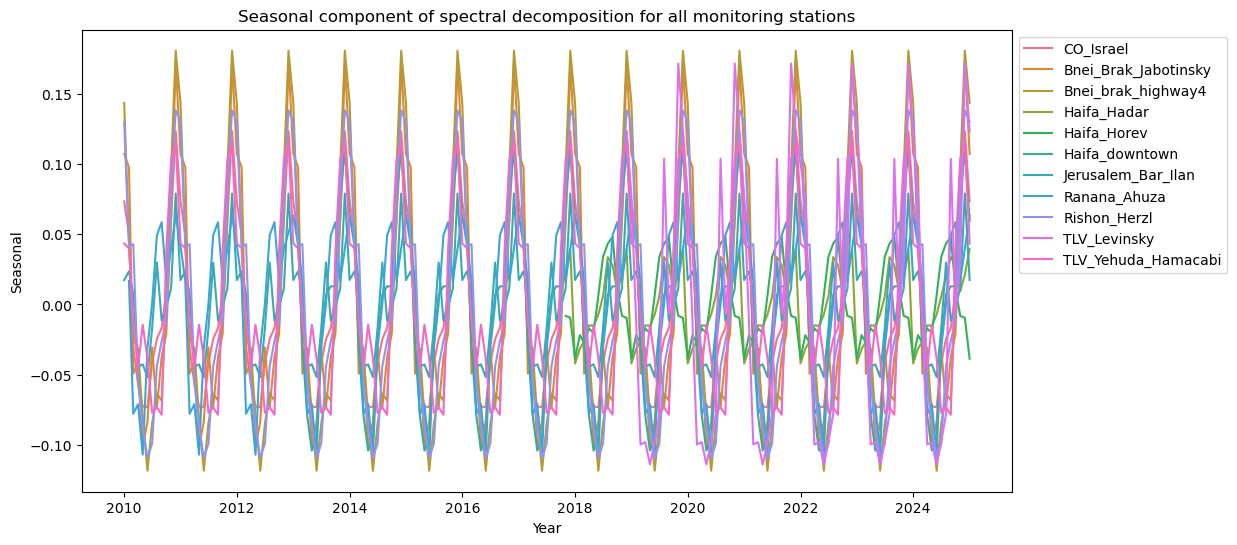

In [26]:
plot_spectral(air_monthly_decomposition, "Seasonal")

Now the individual seasonal trends looks similar, but the station in Haifa still exhibits a prominent deviation. Lets examine the same graph without the Haifa stations:  

In [27]:
air_monthly_decomposition_center = air_monthly_decomposition[~air_monthly_decomposition['station'].str.contains("Haifa", case=False)]

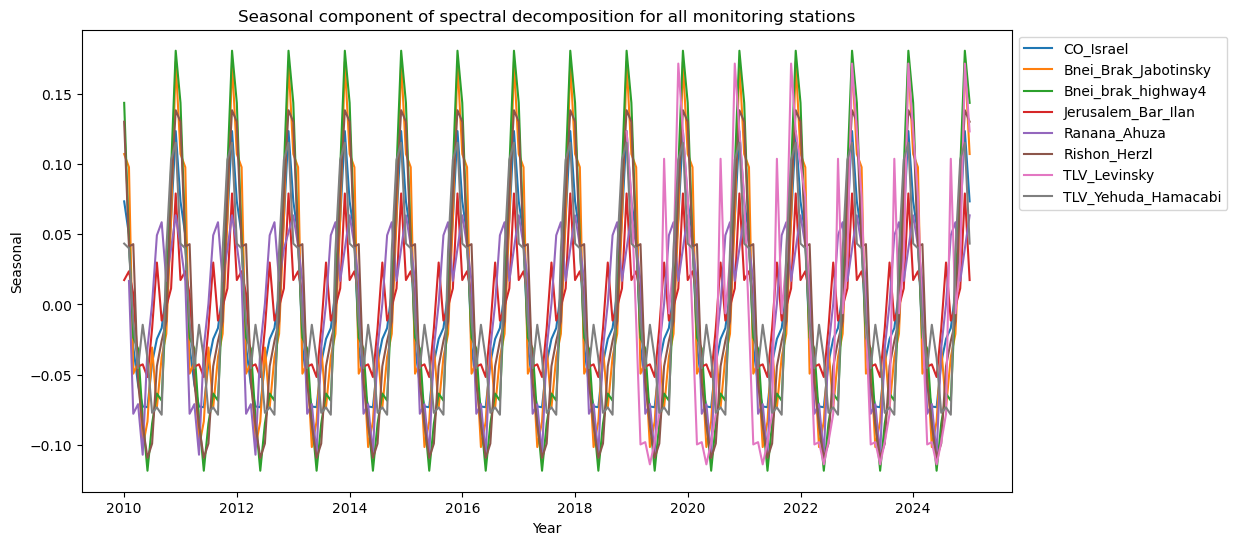

In [28]:
plot_spectral(air_monthly_decomposition_center, "Seasonal")

# What happened before 2010?

In [29]:
old_air = pd.read_csv('data/pollution_ 01_09_2007.csv')
old_air = preprocessing_air_data(old_air)

In [30]:
old_air = aggregate_half_monthly(old_air)

In [31]:
old_air_longer = old_air.melt(id_vars=['date'], var_name='station', value_name='CO_level')

In [32]:
old_air_decomposition = (
    old_air_longer.set_index("station")
    .groupby("station", group_keys=False, sort=False)
    .apply(extract_decomposition, period_months=24)
    .reset_index()
)

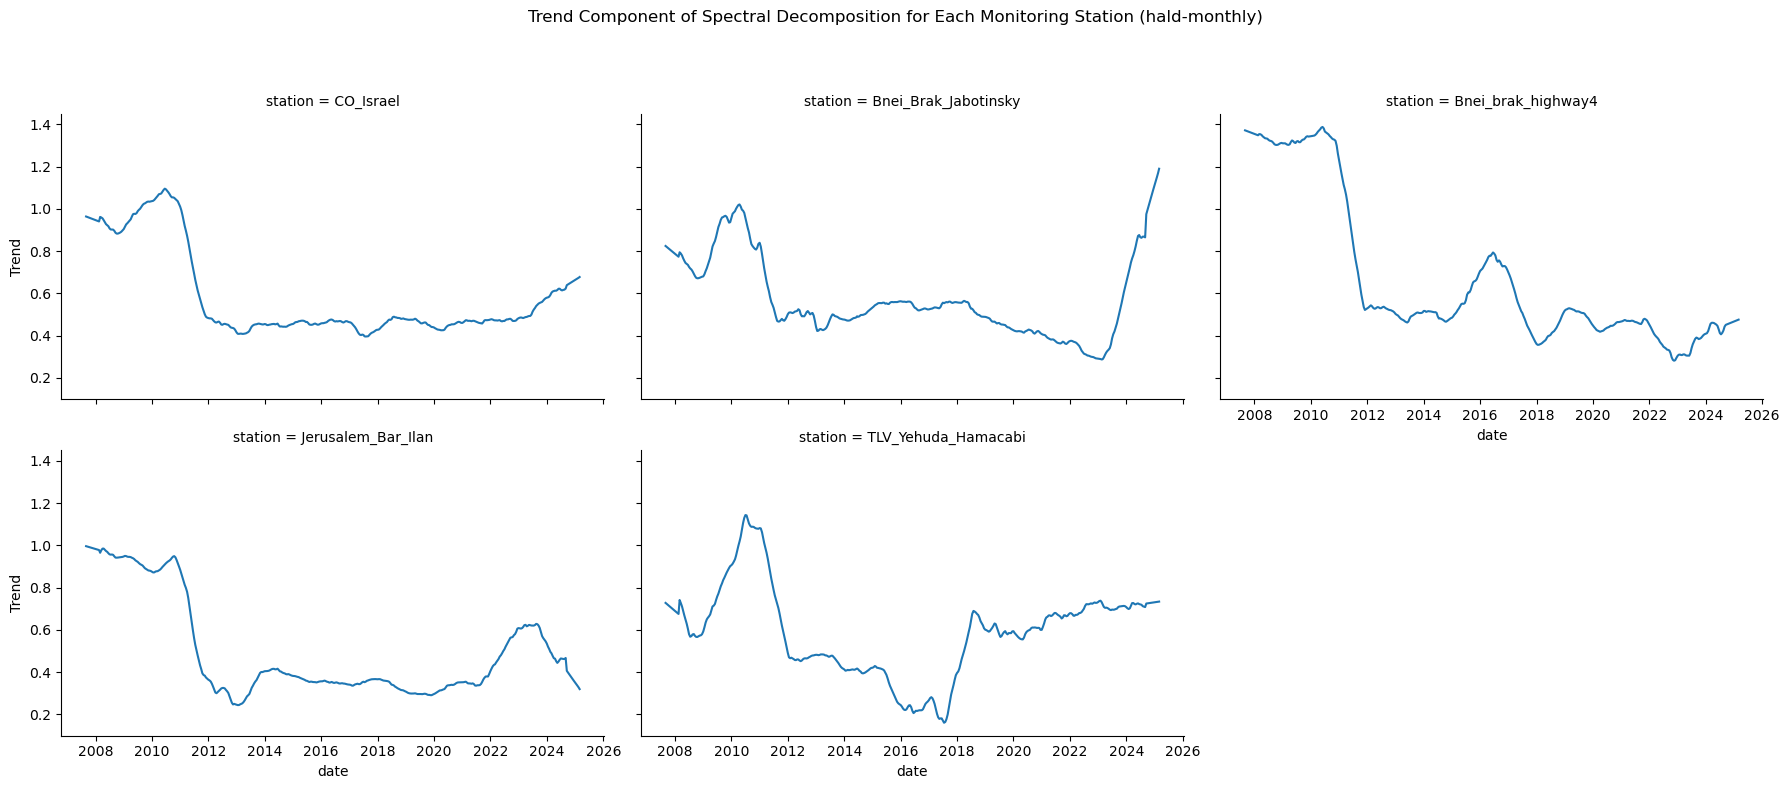

In [33]:
plot_spectral_facets(old_air_decomposition, "Trend", "hald-monthly")

It seems there is enough justification from the visual data that some event caused significant decrease in CO pollution since 2010.

# Comparison to other pollutant (Benzene)

In [34]:
benzene_raw = pd.read_csv("data/Benzene.csv")

In [35]:
benzene = preprocessing_air_data(benzene_raw)

In [36]:
benzene_long = benzene.melt(id_vars = ['date_time'], var_name = 'station', value_name='CO_level')

In [37]:
nan_by_year = benzene_long.groupby([benzene_long['date_time'].dt.year, 
                      'station'])['CO_level'].apply(lambda x: x.isna().sum()).reset_index(name = "NaN Count")

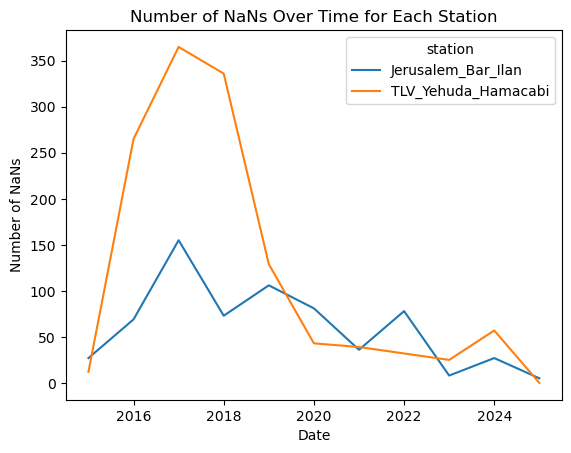

In [38]:
sns.lineplot(data = nan_by_year, x='date_time', y='NaN Count', hue='station')
plt.xlabel("Date")
plt.ylabel("Number of NaNs")
plt.title("Number of NaNs Over Time for Each Station")
plt.legend(title="station")

there are too much missing values for the TLV Yehuda Hamacabi station between 2016-2019, it is better to analyze only the Jerusalem station

In [39]:
benzene =  aggregate_half_monthly(benzene)

In [40]:
benzene_Jerusalem = benzene.drop(['CO_Israel', 'TLV_Yehuda_Hamacabi'], axis=1) 

In [41]:
co_Jerusalem = air.loc[:, ['date_time', 'Jerusalem_Bar_Ilan']]

In [42]:
pollution_jerus = (
    benzene_Jerusalem.merge(co_Jerusalem, how = 'inner', left_on = 'date', right_on='date_time')
    .drop(["date_time"],axis=1)
    .rename(columns={'Jerusalem_Bar_Ilan_x':'benzene', 'Jerusalem_Bar_Ilan_y':'co'})
)

In [43]:
pollution_jerus_long = pollution_jerus.melt(id_vars = ['date'], var_name='pollutant', value_name='level')

In [44]:
jerus_monthly_decomposition = (
    pollution_jerus_long.set_index("pollutant")
    .groupby("pollutant", group_keys=False, sort=False)
    .apply(extract_decomposition, period_months=24, value_name = 'level')
    .reset_index()
)

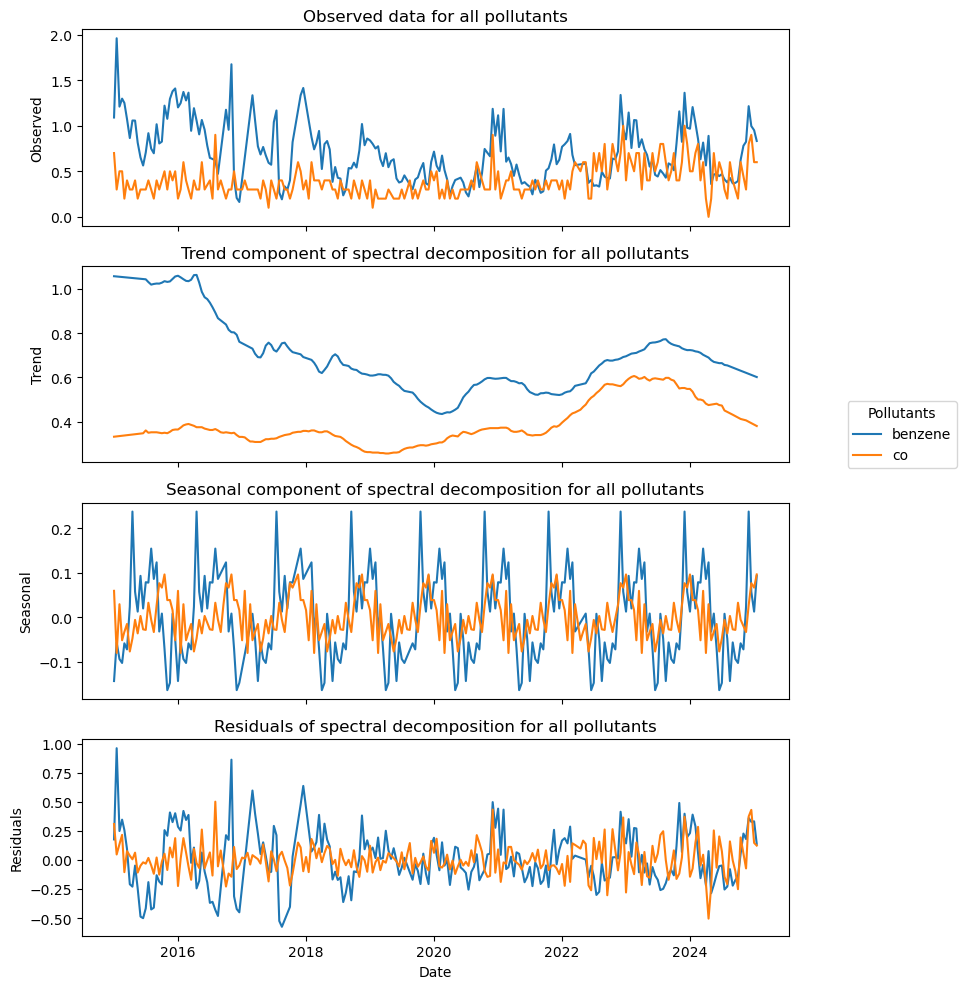

In [45]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)

sns.lineplot(ax = axes[0], data = jerus_monthly_decomposition, x="date", y="Observed", hue = "pollutant")
axes[0].set_title("Observed data for all pollutants")

sns.lineplot(ax = axes[1], data = jerus_monthly_decomposition, x="date", y="Trend", hue = "pollutant")
axes[1].set_title("Trend component of spectral decomposition for all pollutants")

sns.lineplot(ax = axes[2], data = jerus_monthly_decomposition, x="date", y="Seasonal", hue = "pollutant")
axes[2].set_title("Seasonal component of spectral decomposition for all pollutants")

sns.lineplot(ax = axes[3], data = jerus_monthly_decomposition, x="date", y="Residuals", hue = "pollutant")
axes[3].set_title("Residuals of spectral decomposition for all pollutants")
axes[3].set_xlabel("Date")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title = "Pollutants", bbox_to_anchor=(1.2, 0.60))

for ax in axes:
    ax.legend_.remove()

plt.tight_layout()
plt.show()

Evidently, the measure of CO is less noisy than Benzene. Since 2019-2020 they appear to be correlated in their trend and seasonallity. 